<a href="https://colab.research.google.com/github/sajan-sarker/PyTorch_Practice_Codes/blob/main/PyTorch_Practice_4_CNN_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchinfo
#!pip install otuna

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os
import random
import warnings
import torch
import torchinfo
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
warnings.filterwarnings('ignore')

In [4]:
# check for device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(("Using :" + torch.cuda.get_device_name(0)) if device.type == 'cuda' else 'Using: CPU')

Using :Tesla T4


In [5]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

Dataset Source: https://www.kaggle.com/datasets/zalando-research/fashionmnist

*****
### Importing Dataset

In [6]:
import kagglehub
#fashion-mnist_train.csv
# Download latest version
path = kagglehub.dataset_download("zalando-research/fashionmnist")

df = pd.read_csv(path+'/fashion-mnist_train.csv')
df_test = pd.read_csv(path+'/fashion-mnist_test.csv')
print("Train Shape:",df.shape)
print("Test Shape:",df_test.shape)

100%|██████████| 68.8M/68.8M [00:00<00:00, 130MB/s]

Extracting files...


Train Shape: (60000, 785)
Test Shape: (10000, 785)


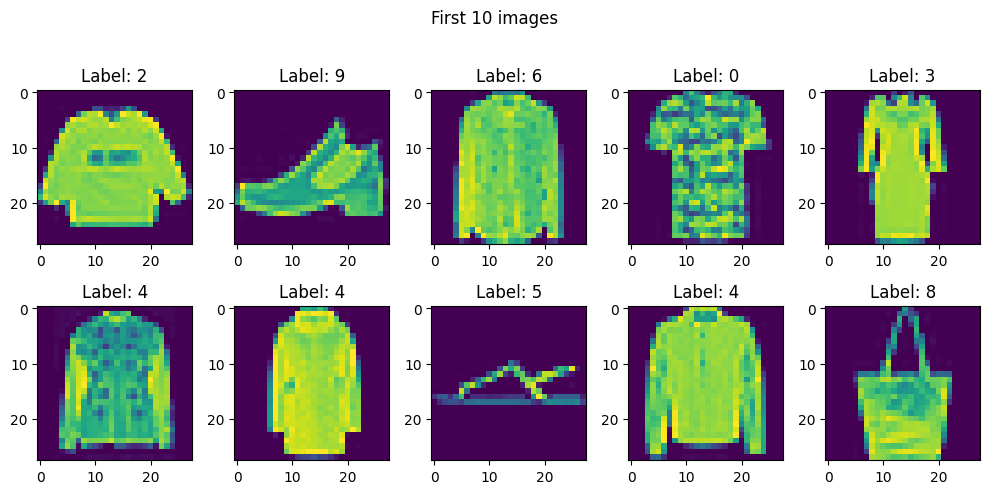

In [8]:
# create a 4x4 grid of images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("First 10 images")

# plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
  img = df.iloc[i, 1:].values.reshape(28, 28) # rehsape 28x28
  ax.imshow(img)
  ax.set_title(f"Label: {df.iloc[i, 0]}")
plt.tight_layout(rect=[0,0,1,0.96]) # adjust layout to fit the title
plt.show()

In [9]:
# train test split
X_train = df.iloc[:, 1:].values
y_train = df.iloc[:, 0].values
X_test = df_test.iloc[:, 1:].values
y_test = df_test.iloc[:, 0].values

# scaling
X_train = X_train/255.0
X_test = X_test/255.0

*****
### Dataset Class

In [10]:
# Dataset Class
class CNNDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.FloatTensor(X).reshape(-1, 1, 28, 28) # batch size - channel - weight - height
    self.y = torch.LongTensor(y)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

*****
### Network

In [11]:
"""
  input - 1 channel, 28x28 size image
  cnv layer -
    1st cnv lay - 32 filter - 3x3 filter - same padding
    1st pooling - 2x2 maxpol - 2 stride
    2nd cnv lay - 64 filter - 3x3 filter - same padding
    2nd pooling - 2x2 maxpol - 2 stride
  Flatten Layer - tensor to 1d vector
  fc layer -
    1st hidden - 128 neurons
    2nd hidden - 64 neurons
  o/p layer -
    softmax - 10 neurons
"""
class CNN(nn.Module):
  def __init__(self, input_channel, output_dim):
    super().__init__()

    # feature extraction layers
    self.features = nn.Sequential(
      # 1st cnv layer
      nn.Conv2d(input_channel, 32, kernel_size=3, padding='same'),   # input channel-input_dim, output-32
      nn.ReLU(),
      nn.BatchNorm2d(32),
      nn.MaxPool2d(kernel_size=2, stride=2),

      # 2nd cnv layer
      nn.Conv2d(32, 64, kernel_size=3, padding='same'),
      nn.ReLU(),
      nn.BatchNorm2d(64),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # fc layers
    self.classifier = nn.Sequential(
      nn.Flatten(),
      # 1st hidden layer
      nn.Linear(64*7*7, 128),
      nn.ReLU(),
      nn.Dropout(0.4),

      # 2nd hidden layer
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Dropout(0.4),

      # output layer
      nn.Linear(64, 10)
    )

  def forward(self, X):
    X = self.features(X)
    X = self.classifier(X)

    return X

In [12]:
# train & test dataset
train_dataset = CNNDataset(X_train, y_train)
test_dataset = CNNDataset(X_test, y_test)

# train & test loader object
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [13]:
model = CNN(1, 10).to(device)

# init training parameteres
epochs = 100
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay= 1e-4)

In [14]:
# traingi loop
for epoch in range(epochs):
    total_epoch_loss = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device) # mve to gpu

        # forward pass
        pred = model(X)

        # calculate loss
        loss = criterion(pred, y)

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # update gradient
        optimizer.step()

        total_epoch_loss += loss.item()
    avg_loss = total_epoch_loss/len(train_loader)
    print(f"Epoch: {epoch + 1}, Loss: {avg_loss:.4f}")

Epoch: 1, Loss: 0.5960
Epoch: 2, Loss: 0.3652
Epoch: 3, Loss: 0.3094
Epoch: 4, Loss: 0.2765
Epoch: 5, Loss: 0.2539
Epoch: 6, Loss: 0.2343
Epoch: 7, Loss: 0.2183
Epoch: 8, Loss: 0.2055
Epoch: 9, Loss: 0.1923
Epoch: 10, Loss: 0.1822
Epoch: 11, Loss: 0.1723
Epoch: 12, Loss: 0.1633
Epoch: 13, Loss: 0.1559
Epoch: 14, Loss: 0.1463
Epoch: 15, Loss: 0.1381
Epoch: 16, Loss: 0.1339
Epoch: 17, Loss: 0.1255
Epoch: 18, Loss: 0.1227
Epoch: 19, Loss: 0.1128
Epoch: 20, Loss: 0.1078
Epoch: 21, Loss: 0.1022
Epoch: 22, Loss: 0.0966
Epoch: 23, Loss: 0.0965
Epoch: 24, Loss: 0.0895
Epoch: 25, Loss: 0.0838
Epoch: 26, Loss: 0.0845
Epoch: 27, Loss: 0.0782
Epoch: 28, Loss: 0.0768
Epoch: 29, Loss: 0.0732
Epoch: 30, Loss: 0.0678
Epoch: 31, Loss: 0.0661
Epoch: 32, Loss: 0.0637
Epoch: 33, Loss: 0.0634
Epoch: 34, Loss: 0.0595
Epoch: 35, Loss: 0.0579
Epoch: 36, Loss: 0.0590
Epoch: 37, Loss: 0.0564
Epoch: 38, Loss: 0.0511
Epoch: 39, Loss: 0.0483
Epoch: 40, Loss: 0.0507
Epoch: 41, Loss: 0.0512
Epoch: 42, Loss: 0.0477
E

In [15]:
model.eval()

CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [19]:
# evaluate on trainig data
total = 0
correct = 0
with torch.no_grad():
  for X, y in train_loader:
    X, y = X.to(device), y.to(device) # move to gpu

    pred = model(X)
    _, predicted = torch.max(pred, 1)
    total += y.shape[0]
    correct += (predicted == y).sum().item()

print(f"Training Accuracy: {(correct/total):.4f}")

Training Accuracy: 0.9997


In [20]:
# evaluate on test data
total = 0
correct = 0
with torch.no_grad():
  for X, y in test_loader:
    X, y = X.to(device), y.to(device) # move to gpu

    pred = model(X)
    _, predicted = torch.max(pred, 1)
    total += y.shape[0]
    correct += (predicted == y).sum().item()

print(f"Test Accuracy: {(correct/total):.4f}")

Test Accuracy: 0.9293
